In [1]:
import sys
fc_src = "../.."
sys.path.insert(0, fc_src)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 106.0.5249
[WDM] - Get LATEST driver version for 106.0.5249
[WDM] - Driver [/Users/gaignard-a/.wdm/drivers/chromedriver/mac64/106.0.5249.61/chromedriver] found in cache


# Retrieve a Bioschemas RDF dump

In [2]:
dump = "bioschemas-dump.ttl"
if not path.isfile(dump):
    r = requests.get("https://github.com/bio-tools/content/raw/master/datasets/bioschemas-dump.ttl")
    assert r.status_code == 200
    with open(dump, "wb") as f:
        f.write(r.content)

assert path.isfile(dump)

# Load the RDF dump

In [3]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

In [4]:
KG = ConjunctiveGraph()
KG.parse(dump, format="turtle")
print(f"{len(KG)} loaded triples")

492085 loaded triples


In [5]:
index = {}
for s, p, o in KG.triples((None, RDF.type, schema.SoftwareApplication)):
    index[str(s)] = None    
print(print(f"{len(index)} software applications"))

25436 software applications
None


In [6]:
def index_dump():
    for i in tqdm(index.keys()):
        sub_graph = ConjunctiveGraph()
        for s, p, o in KG.triples((URIRef(i), None, None)):
            sub_graph.add((s, p, o))
        index[i]=sub_graph


def get_RDF_sparql(bio_tools_Id):
    q = f"CONSTRUCT {{<{bio_tools_Id}> ?p ?o}} WHERE {{<{bio_tools_Id}> rdf:type schema:SoftwareApplication . <{bio_tools_Id}> ?p ?o .}}"
    res = KG.query(q)
    print(res.serialize(format="turtle"))

def get_RDF(bio_tools_Id):
    sub_graph = ConjunctiveGraph()
    for s, p, o in KG.triples((URIRef(bio_tools_Id), None, None)):
        sub_graph.add((s, p, o))
    print(sub_graph.serialize(format="turtle"))    
    
#get_RDF_sparql("https://bio.tools/bwa")
#get_RDF("https://bio.tools/bwa")

In [7]:
index_dump()

  0%|          | 0/25436 [00:00<?, ?it/s]

# Sampling 10 entries

In [8]:
import random
#sample_tool = random.choice(index.keys())

random.seed(10)

samples = random.sample(list(index.items()), 10)
#samples = random.sample(list(index.items()), len(index.items()))

splitedSize = 1000
samples_chunks = [samples[x:x+splitedSize] for x in range(0, len(samples), splitedSize)]

# Evaluating 10 entries

In [9]:
metrics_collection_remote = []
metrics_collection_remote.append(FAIRMetricsFactory.get_F2B(None))
metrics_collection_remote.append(FAIRMetricsFactory.get_I2(None))
metrics_collection_remote.append(FAIRMetricsFactory.get_R13(None))

df_columns = ['ID']
for m in metrics_collection_remote:
    #print(m.get_principle_tag())
    df_columns.append(m.get_principle_tag())
    

In [10]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection_remote = []
    metrics_collection_remote.append(FAIRMetricsFactory.get_F2B(web_res))
    metrics_collection_remote.append(FAIRMetricsFactory.get_I2(web_res))
    metrics_collection_remote.append(FAIRMetricsFactory.get_R13(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in metrics_collection_remote:
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time

In [11]:
def mass_eval(samples):
    evals = []
    exec_time = []

    for sample in tqdm(samples):
        wr = WebResource(url=sample[0], rdf_graph=sample[1])
        row, row_time = eval_metrics(wr)
        evals.append(row)
        exec_time.append(row_time)
        
    
    return evals, exec_time

In [12]:
import logging
logging.getLogger().setLevel(logging.ERROR)

i = 0
for c in tqdm(samples_chunks):
    i += 1
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    
    evals, exec_time = mass_eval(c)
    df = pd.concat([df, pd.DataFrame.from_records(evals)])
    df_time = pd.concat([df_time, pd.DataFrame.from_records(exec_time)])
    
    df.to_csv("../results/biotools/FC_results_long_metrics_"+str(i)+".csv")
    df_time.to_csv("../results/biotools/exec_time_long_metrics_"+str(i)+".csv")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fa4e1450-167b-4947-bf46-e123db4ca3c4:Strong evaluation:
INFO:fa4e1450-167b-4947-bf46-e123db4ca3c4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:fa4e1450-167b-4947-bf46-e123db4ca3c4:All classes found in those ontology registries
INFO:fa4e1450-167b-4947-bf46-e123db4ca3c4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:fa4e1450-167b-4947-bf46-e123db4ca3c4:All properties found in those ontology registries
INFO:fa4e1450-167b-4947-bf46-e123db4ca3c4:All classes and properties are known in major ontology registries
INFO:9888be9c-d626-4592-ace5-29203da70f47:Strong evaluation:
INFO:9888be9c-d626-4592-ace5-29203da70f47:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9888be9c-d626-4592-ace5-29203da70f47:All classes found in those ontology registries
INFO:9888be9c-d626-4592-ace5-29203da70f47:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9888be9c-d626-4592-ace5-29203da70

INFO:39a29ea3-f243-4862-b77f-d264687090fd:Strong evaluation:
INFO:39a29ea3-f243-4862-b77f-d264687090fd:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:39a29ea3-f243-4862-b77f-d264687090fd:All classes found in those ontology registries
INFO:39a29ea3-f243-4862-b77f-d264687090fd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:39a29ea3-f243-4862-b77f-d264687090fd:All properties found in those ontology registries
INFO:39a29ea3-f243-4862-b77f-d264687090fd:All classes and properties are known in major ontology registries
INFO:ec84cc74-857b-4d07-a0c3-67e94deecf4b:Strong evaluation:
INFO:ec84cc74-857b-4d07-a0c3-67e94deecf4b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ec84cc74-857b-4d07-a0c3-67e94deecf4b:All classes found in those ontology registries
INFO:ec84cc74-857b-4d07-a0c3-67e94deecf4b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ec84cc74-857b-4d07-a0c3-67e94deec

INFO:b584fcbc-ab8f-481e-a19f-38376d31a14b:Strong evaluation:
INFO:b584fcbc-ab8f-481e-a19f-38376d31a14b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b584fcbc-ab8f-481e-a19f-38376d31a14b:All classes found in those ontology registries
INFO:b584fcbc-ab8f-481e-a19f-38376d31a14b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b584fcbc-ab8f-481e-a19f-38376d31a14b:All properties found in those ontology registries
INFO:b584fcbc-ab8f-481e-a19f-38376d31a14b:All classes and properties are known in major ontology registries
INFO:e08a2f05-e00e-41cf-ae94-d58b2c4a6b5f:Strong evaluation:
INFO:e08a2f05-e00e-41cf-ae94-d58b2c4a6b5f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e08a2f05-e00e-41cf-ae94-d58b2c4a6b5f:All classes found in those ontology registries
INFO:e08a2f05-e00e-41cf-ae94-d58b2c4a6b5f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e08a2f05-e00e-41cf-ae94-d58b2c4a6

In [13]:
df

,ID,F2B,I2,R1.3
0,https://bio.tools/pmle,2,2,2
1,https://bio.tools/DPre,2,2,2
2,https://bio.tools/lnlcorr,2,2,2
3,https://bio.tools/molligen,1,1,1
4,https://bio.tools/pr2-primers,2,2,2
5,https://bio.tools/BeanMine,1,1,1
6,https://bio.tools/cellnetanalyzer,1,1,1
7,https://bio.tools/methylscaper,2,2,2
8,https://bio.tools/msfilereader_python_bindings,1,1,1
9,https://bio.tools/dp2,2,2,2


In [14]:
df_time

,ID,F2B,I2,R1.3
0,https://bio.tools/pmle,4.26,0.01,0.01
1,https://bio.tools/DPre,0.36,0.01,0.01
2,https://bio.tools/lnlcorr,0.01,0.01,0.02
3,https://bio.tools/molligen,6.49,0.02,0.02
4,https://bio.tools/pr2-primers,0.01,0.01,0.01
5,https://bio.tools/BeanMine,4.54,0.02,0.02
6,https://bio.tools/cellnetanalyzer,0.02,0.02,0.02
7,https://bio.tools/methylscaper,0.01,0.01,0.01
8,https://bio.tools/msfilereader_python_bindings,0.02,0.02,0.02
9,https://bio.tools/dp2,0.01,0.01,0.01


# Plotting results

In [15]:
import glob

all_files = glob.glob("../results/biotools/FC_results_long*.csv")

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
from upsetplot import generate_counts, from_contents, generate_samples, UpSet, plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

F2B = df[((df["F2B"].astype(int) > 0))]["ID"]
I2 = df[((df["I2"].astype(int) > 0))]["ID"]
R13 = df[((df["R1.3"].astype(int) > 0))]["ID"]

df_upset = from_contents({'F2B': F2B, 
                          'I2': I2, 
                          'R13': R13})
df_upset

id
F2B  I2   R13                                                 
True True True                          https://bio.tools/pmle
          True                          https://bio.tools/DPre
          True                       https://bio.tools/lnlcorr
          True                      https://bio.tools/molligen
          True                   https://bio.tools/pr2-primers
          True                      https://bio.tools/BeanMine
          True               https://bio.tools/cellnetanalyzer
          True                  https://bio.tools/methylscaper
          True  https://bio.tools/msfilereader_python_bindings
          True                           https://bio.tools/dp2

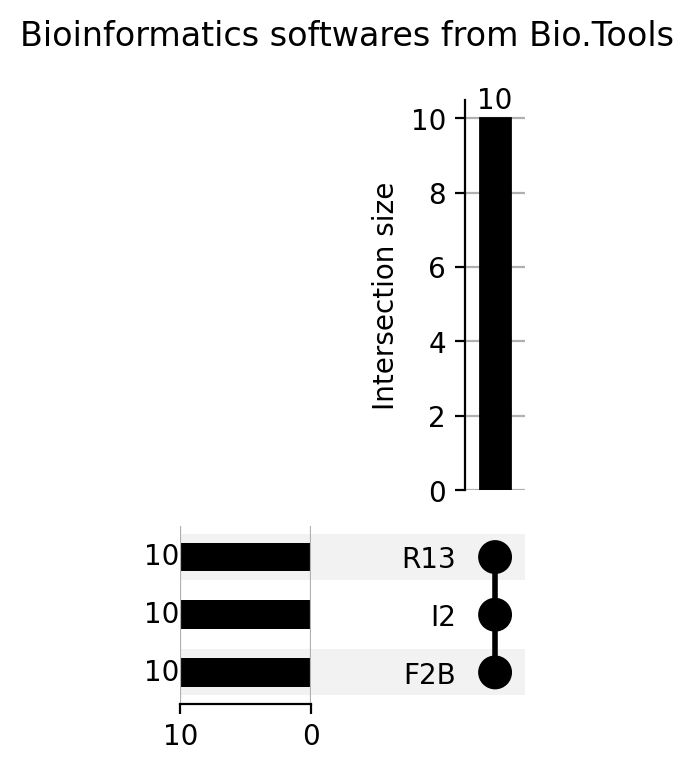

In [17]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("Bioinformatics softwares from Bio.Tools")
plt.savefig('../results/biotools-F2B-I2-R13.png', format="png")
plt.show()

/var/folders/x1/d1nyvpvs0td0htxzsv9x6ggw0000gn/T/ipykernel_3964/2221805510.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_time.drop('ID', 1, inplace=True)


1.573
0.014000000000000002
0.015


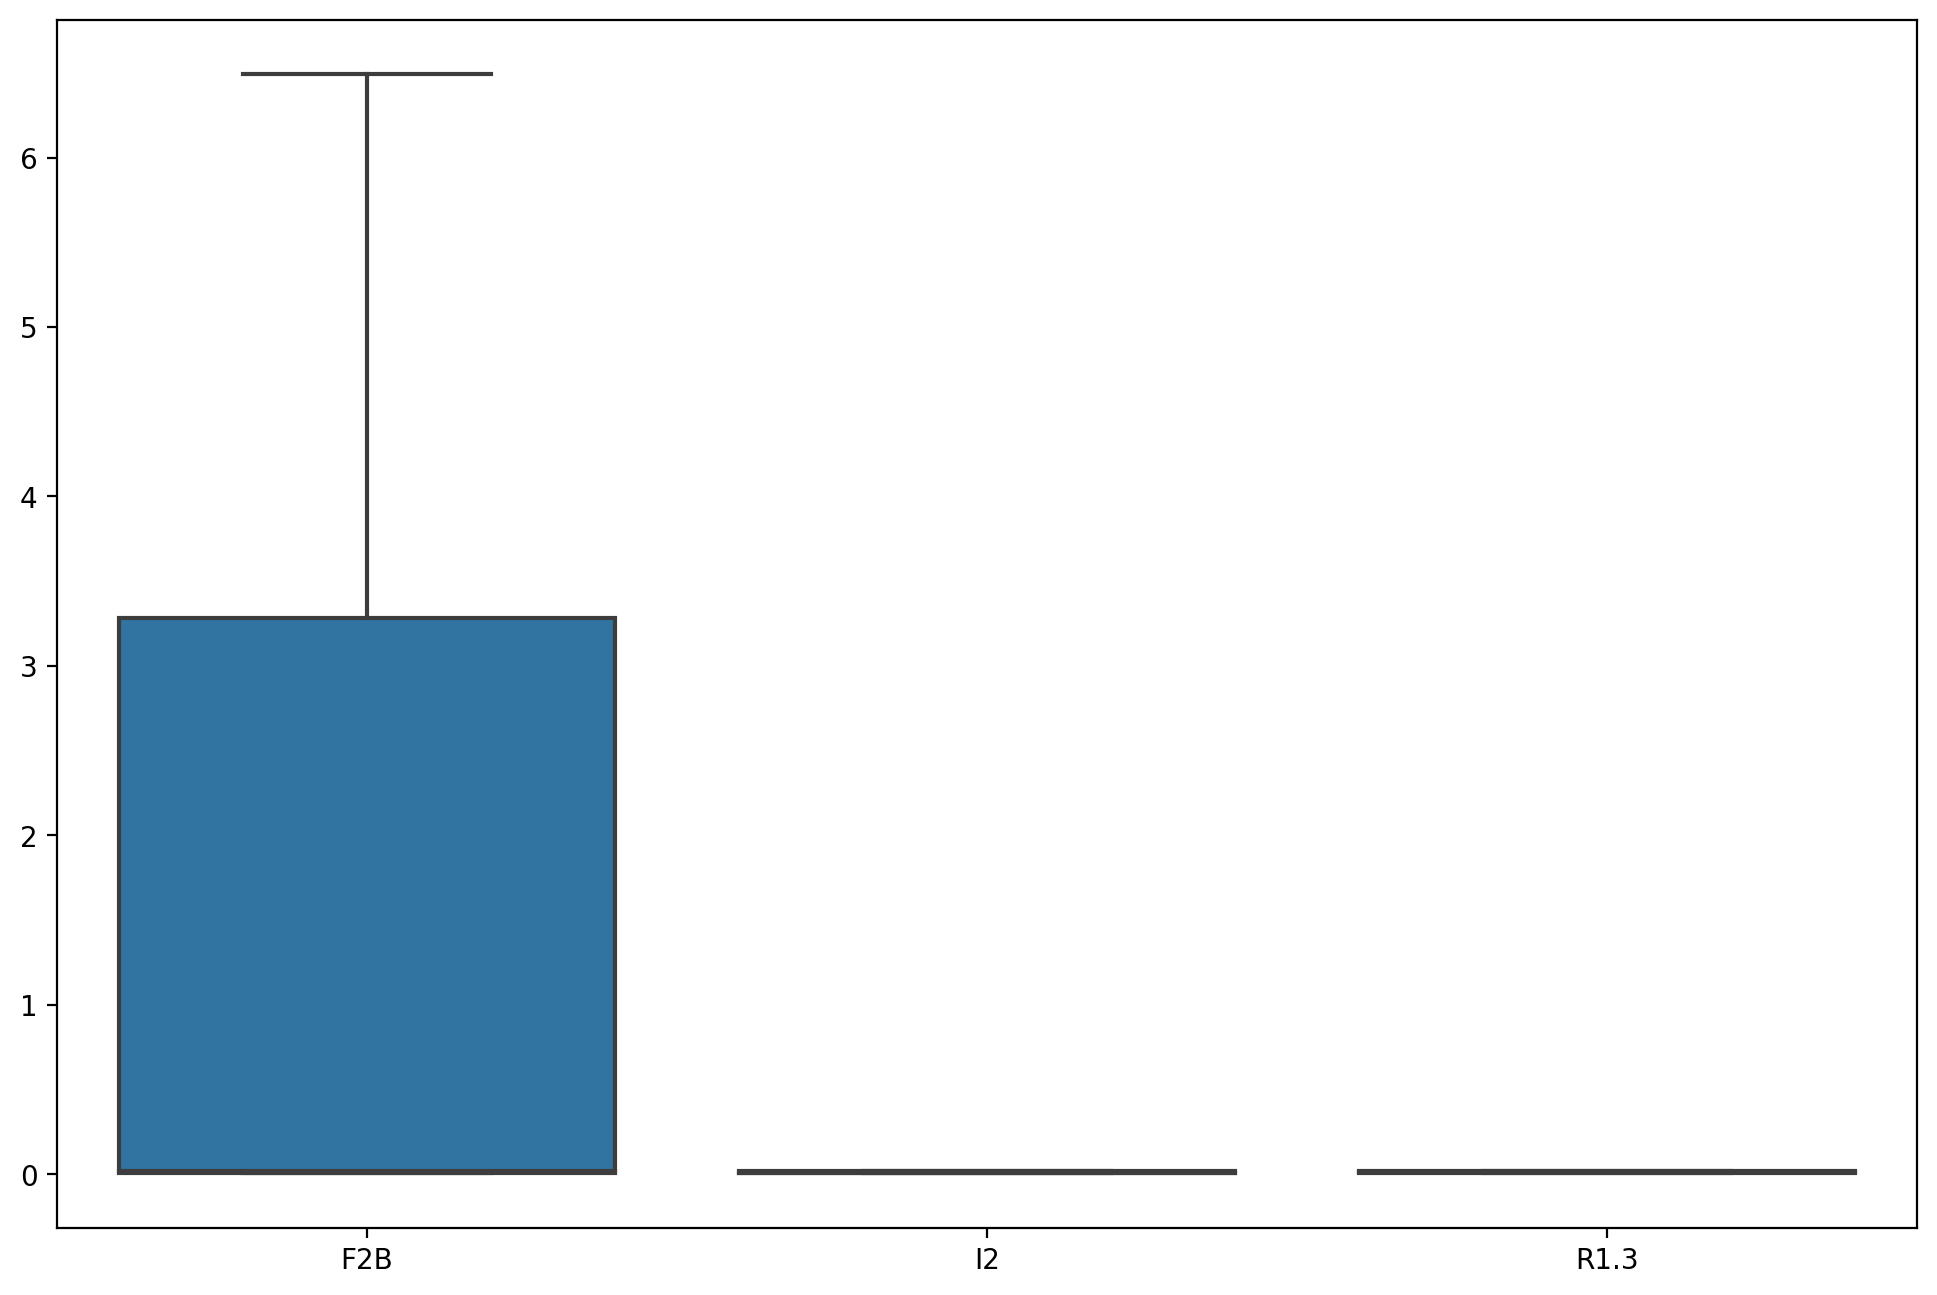

In [18]:
import seaborn as sns

df_time.drop('ID', 1, inplace=True)

sns.boxplot(data=df_time)
plt.savefig('../results/exec_time.png')
print(df_time["F2B"].mean())
print(df_time["I2"].mean())
print(df_time["R1.3"].mean())